In [1]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.core import CoordsToValsJoiner
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import AbstractCountAndProfileTransformer 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import LogCountsPlusOne
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import SmoothProfiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import BigWigReader 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import smooth_profiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import rolling_window
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import MultiTrackCountsAndProfile
from keras_genomics.layers.convolutional import RevCompConv1D
from seqdataloader.batchproducers.coordbased.core import Coordinates, KerasBatchGenerator, apply_mask
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import keras
import keras.layers as kl
from keras.models import load_model
from keras.utils import CustomObjectScope
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import optparse
import os

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/pho4_pbexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [3]:
seq_len = 546
out_pred_len = 200
task_names = "pho4"
test_chrms = ["chrX", "chrXI"]
peaks = []
with open("data/pho4_pbexo/pho4.pbexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        peaks.append((chrm, start, end))

def readChromSizes(chrom_sizes_file):
    chrom_size_list = []
    for line in open(chrom_sizes_file):
        (chrom, size) = line.rstrip().split("\t")[0:2]
        chrom_size_list.append((chrom,int(size)))
    return chrom_size_list

chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

def customChromSizeSort(c):
    return chrms.index(c[0])

from pyfaidx import Fasta
genome_object = Fasta("/users/amr1/pho4/data/genome/sacCer3.genome.fa")

chrom_sizes = readChromSizes("/users/amr1/pho4/data/genome/sacCer3.chrom.sizes")
chrom_sizes.sort(key=customChromSizeSort)

num_chroms = len(chrom_sizes)

fasta_sequences = []
for chrom in chrom_sizes:
    chrom_num = chrom[0]
    chrom_size = chrom[1]
    fasta_sequences.append(genome_object[chrom_num][0:chrom_size].seq)
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

seq_peaks = []
for peak in peaks:
    if peak[0] == "chrX":
        chrmNum = 9
    elif peak[0] == "chrXI":
        chrmNum = 10
    else:
        print("ERROR: Unexpected chromosome")
    seq = fasta_sequences[chrmNum][peak[1]:peak[2]]
    if len(seq) == seq_len:
        seq_peaks.append(seq)

def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]
    for nuc_id, nuc in enumerate(insert):
        if nuc == 'N':
            new_seq += seq[flank+nuc_id]
        else:
            new_seq += nuc
    new_seq += seq[flank+len(insert):]
    return new_seq

motif = "GTCACGTGAC"
candidates = []
for seq in seq_peaks:
    candidates.append(fill_into_center(dinuc_shuffle(seq), motif))
preds = model.predict([getOneHot(candidates), np.zeros((len(candidates),)), np.zeros((len(candidates),out_pred_len,2))])
count_preds = np.mean(preds[0], axis=1)
background = candidates[np.argmin(count_preds)]

In [4]:
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [5]:
mirror_dict = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def getMirror(pattern):
    ret = ""
    for letter in pattern:
        ret += mirror_dict[letter]
    return ret[::-1]

def getRepeat(repeatLen, repeatPattern, stack='left', mirror=False):
    if stack == 'left':
        ret = repeatPattern * int(repeatLen/len(repeatPattern))
        if repeatLen%len(repeatPattern) != 0:
            ret = repeatPattern[-repeatLen%len(repeatPattern):] + ret
        return ret
    elif stack == 'right':
        ret = repeatPattern * int(repeatLen/len(repeatPattern))
        ret += repeatPattern[:repeatLen%len(repeatPattern)]
        return ret
    elif stack == 'both':
        if mirror:
            return (getRepeat(repeatLen, repeatPattern, stack='left', mirror=False),
                    getRepeat(repeatLen, getMirror(repeatPattern), stack='right', mirror=False))
        else:
            return (getRepeat(repeatLen, repeatPattern, stack='left', mirror=False),
                    getRepeat(repeatLen, repeatPattern, stack='right', mirror=False))
    else:
        print("unrecognized argument for stack")
        return None

left only

In [6]:
repeatPattern = "GT"
seqs = []
for repeatLen in range(int((seq_len-len(motif))/2)):
    repeat = getRepeat(repeatLen, repeatPattern, stack='left', mirror=False)
    insert = repeat + motif
    start = int((seq_len/2)-(len(motif)/2))-repeatLen
    end = int((seq_len/2)+(len(motif)/2))
    seqs.append(background[:start] + insert + background[end:])    
test_seqs = getOneHot(seqs)
test_preds = model.predict([test_seqs, np.zeros((len(seqs),)),np.zeros((len(seqs),out_pred_len,2))])
test_preds_logcount = test_preds[0]
test_preds_profile = test_preds[1]
test_post_counts_hypimps = profile_model_counts_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), 1))],
    progress_message=10)[0]
test_post_profile_hypimps = profile_model_profile_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), out_pred_len, 2))],
    progress_message=10)[0]
test_post_counts_hypimps = np.array(test_post_counts_hypimps)
test_post_profile_hypimps = np.array(test_post_profile_hypimps)
test_post_counts_actualimps = test_post_counts_hypimps*test_seqs
test_post_profile_actualimps = test_post_profile_hypimps*test_seqs

Done 0 examples of 268
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Done 100 examples of 268
Done 110 examples of 268
Done 120 examples of 268
Done 130 examples of 268
Done 140 examples of 268
Done 150 examples of 268
Done 160 examples of 268
Done 170 examples of 268
Done 180 examples of 268
Done 190 examples of 268
Done 200 examples of 268
Done 210 examples of 268
Done 220 examples of 268
Done 230 examples of 268
Done 240 examples of 268
Done 250 examples of 268
Done 260 examples of 268
Done 0 examples of 268
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Don

idx 0
Predcounts [5.8811126 5.984125 ]
counts imp
profile imp
idx 1
Predcounts [5.7282085 5.8145237]
counts imp
profile imp
idx 2
Predcounts [6.601023 6.733808]
counts imp
profile imp
idx 3
Predcounts [6.601023 6.733808]
counts imp
profile imp
idx 4
Predcounts [6.601023 6.733808]
counts imp
profile imp
idx 5
Predcounts [6.7864594 6.9224896]
counts imp
profile imp
idx 6
Predcounts [8.239661 8.393493]
counts imp
profile imp
idx 7
Predcounts [19.830698 20.314054]
counts imp
profile imp
idx 8
Predcounts [19.830698 20.314054]
counts imp
profile imp
idx 9
Predcounts [8.86242  9.026208]
counts imp
profile imp
idx 10
Predcounts [8.857937 9.057907]
counts imp
profile imp
idx 11
Predcounts [8.314339 8.503624]
counts imp
profile imp
idx 12
Predcounts [8.314339 8.503624]
counts imp
profile imp
idx 13
Predcounts [8.530724 8.696703]
counts imp
profile imp
idx 14
Predcounts [8.611283 8.823265]
counts imp
profile imp
idx 15
Predcounts [8.907285 9.154518]
counts imp
profile imp
idx 16
Predcounts [9.607

Text(0.5, 1.0, "'GT' repeats left of motif")

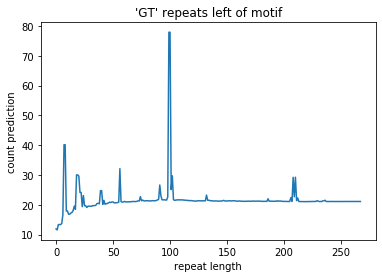

In [7]:
counts = []
for idx in range(len(seqs)): 
    print("idx",idx)
    predcounts = np.exp(test_preds_logcount[idx])-1
    print("Predcounts",predcounts)
    counts.append(np.sum(predcounts))
    fig = plt.figure(figsize=(20,9))
    for oneovertemp in [1.0]:
        pred_profile = ((np.exp(test_preds_logcount[idx])-1)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        ax1 = fig.add_subplot(311) 
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.ylim((-0.45, 0.3))
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    print("counts imp")
    ax2 = fig.add_subplot(312) 
    viz_sequence.plot_weights_given_ax(ax=ax2, array=test_post_counts_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax2.set_ylim((-0.2, 0.6))

    print("profile imp")
    ax3 = fig.add_subplot(313)
    viz_sequence.plot_weights_given_ax(ax=ax3, array=test_post_profile_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax3.set_ylim((-0.05, 0.1))
    fig.savefig('data/gif_showcase/left/'+str(idx)+'.png')
    plt.close(fig)

plt.plot(range(len(seqs)), counts)
plt.xlabel("repeat length")
plt.ylabel("count prediction")
plt.title("'GT' repeats left of motif")

right only

In [8]:
repeatPattern = "GT"
seqs = []
for repeatLen in range(int((seq_len-len(motif))/2)):
    repeat = getRepeat(repeatLen, repeatPattern, stack='right', mirror=False)
    insert = motif + repeat
    start = int((seq_len/2)-(len(motif)/2))
    end = int((seq_len/2)+(len(motif)/2))+repeatLen
    seqs.append(background[:start] + insert + background[end:])    
test_seqs = getOneHot(seqs)
test_preds = model.predict([test_seqs, np.zeros((len(seqs),)),np.zeros((len(seqs),out_pred_len,2))])
test_preds_logcount = test_preds[0]
test_preds_profile = test_preds[1]
test_post_counts_hypimps = profile_model_counts_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), 1))],
    progress_message=10)[0]
test_post_profile_hypimps = profile_model_profile_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), out_pred_len, 2))],
    progress_message=10)[0]
test_post_counts_hypimps = np.array(test_post_counts_hypimps)
test_post_profile_hypimps = np.array(test_post_profile_hypimps)
test_post_counts_actualimps = test_post_counts_hypimps*test_seqs
test_post_profile_actualimps = test_post_profile_hypimps*test_seqs

Done 0 examples of 268
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Done 100 examples of 268
Done 110 examples of 268
Done 120 examples of 268
Done 130 examples of 268
Done 140 examples of 268
Done 150 examples of 268
Done 160 examples of 268
Done 170 examples of 268
Done 180 examples of 268
Done 190 examples of 268
Done 200 examples of 268
Done 210 examples of 268
Done 220 examples of 268
Done 230 examples of 268
Done 240 examples of 268
Done 250 examples of 268
Done 260 examples of 268
Done 0 examples of 268
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Done 100 examples of 268
Done 110 examples of 268
Done 120 examples of 268
Done 130 examples of 2

idx 0
Predcounts [5.8811126 5.984125 ]
counts imp
profile imp
idx 1
Predcounts [5.8811126 5.984125 ]
counts imp
profile imp
idx 2
Predcounts [6.3116865 6.424875 ]
counts imp
profile imp
idx 3
Predcounts [8.054025 8.208659]
counts imp
profile imp
idx 4
Predcounts [8.622571 8.833876]
counts imp
profile imp
idx 5
Predcounts [10.745049 11.009967]
counts imp
profile imp
idx 6
Predcounts [9.679779 9.900745]
counts imp
profile imp
idx 7
Predcounts [9.679779 9.900745]
counts imp
profile imp
idx 8
Predcounts [9.679779 9.900745]
counts imp
profile imp
idx 9
Predcounts [9.609698 9.788093]
counts imp
profile imp
idx 10
Predcounts [9.609698 9.788093]
counts imp
profile imp
idx 11
Predcounts [ 9.965814 10.152562]
counts imp
profile imp
idx 12
Predcounts [8.990002 9.162704]
counts imp
profile imp
idx 13
Predcounts [8.993284 9.168555]
counts imp
profile imp
idx 14
Predcounts [8.762691 8.995603]
counts imp
profile imp
idx 15
Predcounts [8.163389 8.368148]
counts imp
profile imp
idx 16
Predcounts [8.274

Text(0.5, 1.0, "'GT' repeats right of motif")

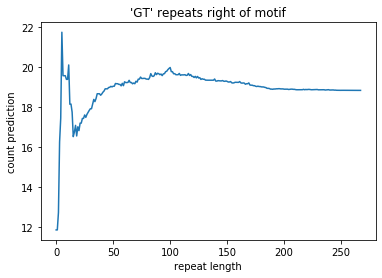

In [9]:
counts = []
for idx in range(len(seqs)): 
    print("idx",idx)
    predcounts = np.exp(test_preds_logcount[idx])-1
    print("Predcounts",predcounts)
    counts.append(np.sum(predcounts))
    fig = plt.figure(figsize=(20,9))
    for oneovertemp in [1.0]:
        pred_profile = ((np.exp(test_preds_logcount[idx])-1)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        ax1 = fig.add_subplot(311) 
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.ylim((-0.45, 0.3))
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    print("counts imp")
    ax2 = fig.add_subplot(312) 
    viz_sequence.plot_weights_given_ax(ax=ax2, array=test_post_counts_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax2.set_ylim((-0.2, 0.6))

    print("profile imp")
    ax3 = fig.add_subplot(313)
    viz_sequence.plot_weights_given_ax(ax=ax3, array=test_post_profile_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax3.set_ylim((-0.05, 0.1))
    fig.savefig('data/gif_showcase/right/'+str(idx)+'.png')
    plt.close(fig)

plt.plot(range(len(seqs)), counts)
plt.xlabel("repeat length")
plt.ylabel("count prediction")
plt.title("'GT' repeats right of motif")

both

In [10]:
repeatPattern = "GT"
seqs = []
for repeatLen in range(int((seq_len-len(motif))/2)):
    leftRepeat, rightRepeat = getRepeat(repeatLen, repeatPattern, stack='both', mirror=False)
    insert = leftRepeat + motif + rightRepeat
    start = int((seq_len/2)-(len(motif)/2))-repeatLen
    end = int((seq_len/2)+(len(motif)/2))+repeatLen
    seqs.append(background[:start] + insert + background[end:])    
test_seqs = getOneHot(seqs)
test_preds = model.predict([test_seqs, np.zeros((len(seqs),)),np.zeros((len(seqs),out_pred_len,2))])
test_preds_logcount = test_preds[0]
test_preds_profile = test_preds[1]
test_post_counts_hypimps = profile_model_counts_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), 1))],
    progress_message=10)[0]
test_post_profile_hypimps = profile_model_profile_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), out_pred_len, 2))],
    progress_message=10)[0]
test_post_counts_hypimps = np.array(test_post_counts_hypimps)
test_post_profile_hypimps = np.array(test_post_profile_hypimps)
test_post_counts_actualimps = test_post_counts_hypimps*test_seqs
test_post_profile_actualimps = test_post_profile_hypimps*test_seqs

Done 0 examples of 268
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Done 100 examples of 268
Done 110 examples of 268
Done 120 examples of 268
Done 130 examples of 268
Done 140 examples of 268
Done 150 examples of 268
Done 160 examples of 268
Done 170 examples of 268
Done 180 examples of 268
Done 190 examples of 268
Done 200 examples of 268
Done 210 examples of 268
Done 220 examples of 268
Done 230 examples of 268
Done 240 examples of 268
Done 250 examples of 268
Done 260 examples of 268
Done 0 examples of 268
Done 10 examples of 268
Done 20 examples of 268
Done 30 examples of 268
Done 40 examples of 268
Done 50 examples of 268
Done 60 examples of 268
Done 70 examples of 268
Done 80 examples of 268
Done 90 examples of 268
Done 100 examples of 268
Done 110 examples of 268
Done 120 examples of 268
Done 130 examples of 2

In [ ]:
counts = []
for idx in range(len(seqs)): 
    print("idx",idx)
    predcounts = np.exp(test_preds_logcount[idx])-1
    print("Predcounts",predcounts)
    counts.append(np.sum(predcounts))
    fig = plt.figure(figsize=(20,9))
    for oneovertemp in [1.0]:
        pred_profile = ((np.exp(test_preds_logcount[idx])-1)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        ax1 = fig.add_subplot(311) 
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.ylim((-0.45, 0.3))
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    print("counts imp")
    ax2 = fig.add_subplot(312) 
    viz_sequence.plot_weights_given_ax(ax=ax2, array=test_post_counts_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax2.set_ylim((-0.2, 0.6))

    print("profile imp")
    ax3 = fig.add_subplot(313)
    viz_sequence.plot_weights_given_ax(ax=ax3, array=test_post_profile_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax3.set_ylim((-0.05, 0.1))
    fig.savefig('data/gif_showcase/both/'+str(idx)+'.png')
    plt.close(fig)

plt.plot(range(len(seqs)), counts)
plt.xlabel("repeat length")
plt.ylabel("count prediction")
plt.title("'GT' repeats both left and right of motif")

idx 0
Predcounts [5.8811126 5.984125 ]
counts imp
profile imp
idx 1
Predcounts [5.7282085 5.8145237]
counts imp
profile imp
idx 2
Predcounts [6.4183493 6.565159 ]
counts imp
profile imp
idx 3
Predcounts [7.859454 8.052372]
counts imp
profile imp
idx 4
Predcounts [8.784651 9.031134]
counts imp
profile imp
idx 5
Predcounts [11.497289 11.828049]
counts imp
profile imp
idx 6
Predcounts [12.781998 13.112308]
counts imp
profile imp
idx 7
Predcounts [25.265615 26.032148]
counts imp
profile imp
idx 8
Predcounts [25.265615 26.032148]
counts imp
profile imp
idx 9
Predcounts [12.834095 13.095064]
counts imp
profile imp
idx 10
Predcounts [12.754857 13.062535]
counts imp
profile imp
idx 11
Predcounts [12.58484  12.915429]
counts imp
profile imp
idx 12
Predcounts [11.347299 11.66297 ]
counts imp
profile imp
idx 13
Predcounts [11.613195 11.91508 ]
counts imp
profile imp
idx 14
Predcounts [11.4963   11.929613]
counts imp
profile imp
idx 15
Predcounts [11.071144 11.49092 ]
counts imp
profile imp
idx 16

both mirrored

In [ ]:
repeatPattern = "GT"
seqs = []
for repeatLen in range(int((seq_len-len(motif))/2)):
    leftRepeat, rightRepeat = getRepeat(repeatLen, repeatPattern, stack='both', mirror=True)
    insert = leftRepeat + motif + rightRepeat
    start = int((seq_len/2)-(len(motif)/2))-repeatLen
    end = int((seq_len/2)+(len(motif)/2))+repeatLen
    seqs.append(background[:start] + insert + background[end:])    
test_seqs = getOneHot(seqs)
test_preds = model.predict([test_seqs, np.zeros((len(seqs),)),np.zeros((len(seqs),out_pred_len,2))])
test_preds_logcount = test_preds[0]
test_preds_profile = test_preds[1]
test_post_counts_hypimps = profile_model_counts_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), 1))],
    progress_message=10)[0]
test_post_profile_hypimps = profile_model_profile_explainer.shap_values(
    [test_seqs, np.zeros((len(test_seqs), out_pred_len, 2))],
    progress_message=10)[0]
test_post_counts_hypimps = np.array(test_post_counts_hypimps)
test_post_profile_hypimps = np.array(test_post_profile_hypimps)
test_post_counts_actualimps = test_post_counts_hypimps*test_seqs
test_post_profile_actualimps = test_post_profile_hypimps*test_seqs

In [ ]:
counts = []
for idx in range(len(seqs)): 
    print("idx",idx)
    predcounts = np.exp(test_preds_logcount[idx])-1
    print("Predcounts",predcounts)
    counts.append(np.sum(predcounts))
    fig = plt.figure(figsize=(20,9))
    for oneovertemp in [1.0]:
        pred_profile = ((np.exp(test_preds_logcount[idx])-1)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        ax1 = fig.add_subplot(311) 
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.ylim((-0.45, 0.3))
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    print("counts imp")
    ax2 = fig.add_subplot(312) 
    viz_sequence.plot_weights_given_ax(ax=ax2, array=test_post_counts_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax2.set_ylim((-0.2, 0.6))

    print("profile imp")
    ax3 = fig.add_subplot(313)
    viz_sequence.plot_weights_given_ax(ax=ax3, array=test_post_profile_actualimps[idx][start_view:end_view],
        height_padding_factor=0.2,
        length_padding=1.0,
        subticks_frequency=10,
        highlight={})
    ax3.set_ylim((-0.05, 0.1))
    fig.savefig('data/gif_showcase/both_mirror/'+str(idx)+'.png')
    plt.close(fig)

plt.plot(range(len(seqs)), counts)
plt.xlabel("repeat length")
plt.ylabel("count prediction")
plt.title("'GT/AC' mirrored repeats both left and right of motif")